#### Script Overview
- This script is focused on genomic prediction and GWAS-based trait modeling using machine learning of a single trait. 
- It integrates genotype and phenotype data, extracts significant SNPs, and applies G-BLUP and machine learning models such as Random Forest and XGBoost to predict traits.



In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBRegressor
import cmdstanpy
from cmdstanpy import CmdStanModel



In [ ]:
# Step 1: Define paths
genotype_file = "genotype_qc_analysis/gwas_ready_num.csv"
phenotype_file = "GAPIT_data/pheno_BLUP_INT_cleaned.csv"  
grain_weight_gwas_file = "GWAS_GAPIT/GWAS_individual_results/Grain_weight_GWAS_results.csv"
yield_per_plant_gwas_file = "GWAS_GAPIT/GWAS_individual_results/Yield_per_plant_GWAS_results.csv"


In [7]:
import os
os.getcwd()

'd:\\My projects_Oct 2023\\GWAS\\GWAS_rice\\Scripts'

In [8]:
os.chdir("d:\\My projects_Oct 2023\\GWAS\\GWAS_rice")

In [9]:
# Step 2: Load Significant SNPs
# Load GWAS results for significant SNPs
grain_weight_gwas = pd.read_csv(grain_weight_gwas_file, usecols=["SNP"])
significant_snps_list = grain_weight_gwas["SNP"].tolist()

print(f"Found {len(significant_snps_list)} significant SNPs.")


Found 1178 significant SNPs.


In [10]:
# Step 3: Prepare genotype data
# Step: Read only the header of the genotype file 
with open(genotype_file, "r") as f:
    header_line = f.readline().strip().split(",")


In [11]:
# Step: Identify matching SNPs between GWAS results and Genotype file
available_snps = set(header_line)  # Convert headers to a set
matched_snps = [snp for snp in significant_snps_list if snp in available_snps]

print(f"Found {len(matched_snps)} matching SNPs out of {len(significant_snps_list)} total significant SNPs.")

# Step: Load only required columns (Including IID and MAtching SNPs)
geno_data = pd.read_csv(genotype_file, usecols = ["IID"] + matched_snps, sep = ",")

# Step: Rename "IID" to "Taxa" (For merging with phenotype data)
geno_data.rename(columns = {"IID" : "Taxa"}, inplace = True)


Found 1178 matching SNPs out of 1178 total significant SNPs.


In [12]:
# Step 4: Load Phenotype Data
pheno_data = pd.read_csv(phenotype_file)
print(pheno_data.head())


  Taxa  Yield_per_plant  Panicle_number  Grain_number_per_panicle  \
0   Z1         0.779402       -0.779402                  2.006096   
1   Z2        -0.802340       -0.513267                  0.596457   
2   Z3         1.353057        1.227739                  0.666088   
3   Z4         0.525749        1.227739                  0.979548   
4   Z5         0.830437        0.832808                  0.116872   

   Seed_setting_rate  Grain_weight  Heading_date    Height  Panicle_length  \
0           0.423375     -0.519978      0.843535  1.760558       24.709168   
1          -0.718325     -1.138240      1.714999 -1.726056       22.573128   
2          -0.129552     -0.838756      0.742423  0.478169       24.936676   
3          -1.122350     -1.187730      1.569782  2.059031       24.999872   
4           0.166873     -0.166023     -0.742423 -0.770341       22.863832   

   Grain_length  Grain_width  
0     -1.357259     0.783957  
1     -1.626947     0.441799  
2     -0.117717    -1.1

In [13]:
# Step 5: Merge Phenotype & Genotype Data on "Taxa"
merged_data = pd.merge(pheno_data, geno_data, on = "Taxa", how = "inner")
print(merged_data.head())

  Taxa  Yield_per_plant  Panicle_number  Grain_number_per_panicle  \
0   Z1         0.779402       -0.779402                  2.006096   
1   Z2        -0.802340       -0.513267                  0.596457   
2   Z3         1.353057        1.227739                  0.666088   
3   Z4         0.525749        1.227739                  0.979548   
4   Z5         0.830437        0.832808                  0.116872   

   Seed_setting_rate  Grain_weight  Heading_date    Height  Panicle_length  \
0           0.423375     -0.519978      0.843535  1.760558       24.709168   
1          -0.718325     -1.138240      1.714999 -1.726056       22.573128   
2          -0.129552     -0.838756      0.742423  0.478169       24.936676   
3          -1.122350     -1.187730      1.569782  2.059031       24.999872   
4           0.166873     -0.166023     -0.742423 -0.770341       22.863832   

   Grain_length  ...  5_5377198  5_5377307  5_5377607  5_5377666  5_5377804  \
0     -1.357259  ...          1      

In [ ]:
# Step 6: Save final dataset for ML
output_file = "ML/ML_grain_weight_SNP_data.csv"
merged_data.to_csv(output_file, index = False)

print(f"ML-ready dataset saved as {output_file} with shape: {merged_data.shape}")

ML-ready dataset saved as ML/ML_grain_weight_data.csv with shape: (1494, 1189)


In [14]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Step 7: Define phenotype and genotype columns
pheno_cols = ['Yield_per_plant', 'Panicle_number', 'Grain_number_per_panicle','Seed_setting_rate', 'Grain_weight', 'Heading_date', 'Height','Panicle_length', 'Grain_length', 'Grain_width']

# Genotype columns do not include 'Taxa' column and pheno_cols
geno_cols = [col for col in merged_data.columns if col not in ["Taxa"] + pheno_cols]

# Check if there is any missing value
if merged_data.isnull().values.any():
    print("Missing values found in the merged dataframe.")
else:
    print("No missing values found in the merged dataframe.")


# No need to check for normality since we already did in the last run



No missing values found in the merged dataframe.


In [16]:
# Step 8: Remove non-SNP assessed traits from dataset and only keep 'Grain_weight'
# Keep only 'Grain_weight' and remove other traits from phenotype data
target_trait = "Grain_weight"

# Filter phenotype data to keep only the target trait
pheno_data_filtered = pheno_data[["Taxa", target_trait]]

print(pheno_data_filtered.head())


  Taxa  Grain_weight
0   Z1     -0.519978
1   Z2     -1.138240
2   Z3     -0.838756
3   Z4     -1.187730
4   Z5     -0.166023


In [ ]:
pheno_data_filtered.to_csv("ML/ML_grain_weight_pheno.csv", index = False)

In [17]:
# Step 9: Prepare features and targets
X = merged_data[geno_cols].values # Genotype_data
y = pheno_data_filtered[target_trait].values # filtered phenotype data

print(f" X shape (Genotype): {X.shape}")
print(f" y shape (Phenotype): {y.shape}")


# Check few columns of genotype data
print(merged_data[geno_cols].head())




 X shape (Genotype): (1494, 1178)
 y shape (Phenotype): (1494,)
   3_544296  3_546583  3_546698  3_547516  3_551147  3_551560  3_558235  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         1         1         1         1         1         1         1   
3         0         0         0         0         0         0         0   
4         1         1         1         1         1         1         1   

   3_558328  3_559051  3_559507  ...  5_5377198  5_5377307  5_5377607  \
0         0         0         0  ...          1          1          1   
1         0         0         0  ...          0          0          0   
2         1         1         1  ...          1          1          1   
3         0         0         0  ...          1          1          1   
4         1         1         1  ...          1          1          1   

   5_5377666  5_5377804  5_5377857  5_5378228 

In [18]:
# Compute kinship matrix (G- matrix) 
def compute_kinship(geno_matrix):
    """Computes a genomic relationship matrix (G-matrix)"""
    n_markers = geno_matrix.shape[1]
    kinship_matrix = np.dot(geno_matrix, geno_matrix.T)/ n_markers
    return kinship_matrix

G_matrix = compute_kinship(X)

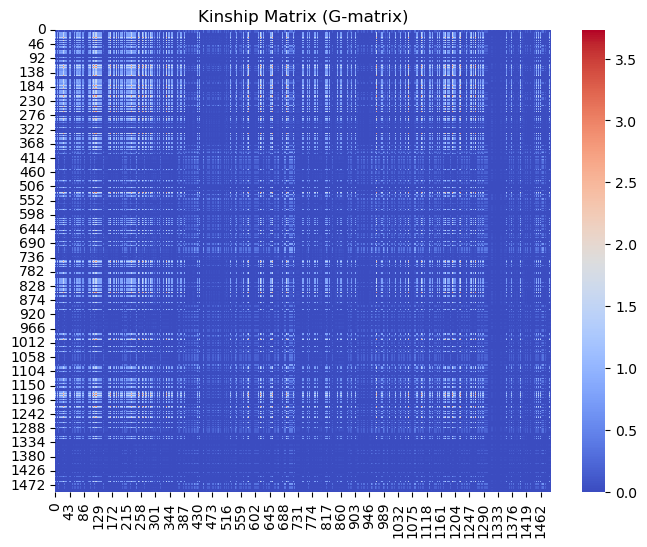

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the kinship matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(G_matrix, cmap="coolwarm", annot=False)
plt.title("Kinship Matrix (G-matrix)")
plt.show()

In [19]:
# Step 10: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")



Train shape: (1195, 1178), (1195,)
Test shape: (299, 1178), (299,)


In [20]:
print(y_train)

[-0.5499855  -1.46138808 -0.11856185 ... -0.08819854  0.08819854
  0.17197928]


In [ ]:
from sklearn.linear_model import Ridge
# G_BLUP model

# Normalize G-matrix by trace
G_matrix /= np.trace(G_matrix) / G_matrix.shape[0] # Normalize kinship matrix

# Initialize GBLUP model
gblup = Ridge(alpha = 0.01)

# Train GBLUP model
gblup.fit(G_matrix, y)

y_pred_gblup = gblup.predict(G_matrix)

rmse_gblup = np.sqrt(mean_squared_error(y, y_pred_gblup))
r2_gblup = r2_score(y, y_pred_gblup)
print(f"G-BLUP Performance -> RMSE: {rmse_gblup:.4f}, R²: {r2_gblup:.4f}")

G-BLUP Performance -> RMSE: 0.7525, R²: 0.4332


G-BLUP Performance -> RMSE: 0.7657, R²: 0.4132

In [ ]:
from sklearn.kernel_ridge import KernelRidge

# Normalize G-matrix by trace
G_matrix /= np.trace(G_matrix) / G_matrix.shape[0] # Normalize kinship matrix

# Use precomputed kernel (G matrix)
gblup_krr = KernelRidge(alpha=0.01, kernel='precomputed')
gblup_krr.fit(G_matrix, y)
y_pred = gblup_krr.predict(G_matrix)

rmse_gblup_krr = np.sqrt(mean_squared_error(y, y_pred))
r2_gblup_krr = r2_score(y, y_pred)
print(f"G-BLUP KernelRidge Performance -> RMSE: {rmse_gblup_krr:.4f}, R²: {r2_gblup_krr:.4f}")

G-BLUP KernelRidge Performance -> RMSE: 0.7300, R²: 0.4665


In [50]:
# Step 10.1: Perform PCA transformation to reduce SNP redundancy
pca = PCA(n_components=100)  # Select based on explained variance
X_pca = pca.fit_transform(X)
y_array = np.array(y)

from sklearn.model_selection import train_test_split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_pca, y_array, test_size=0.2, random_state=42)

stan_data = {
    "N": X_train_PCA.shape[0],
    "P": X_train_PCA.shape[1],
    "X": X_train_PCA,
    "y": y_train_PCA
}


In [51]:
# Step 10.2: Stan model 
stan_models = {
    "Bayesian_Ridge": """
        data {
          int<lower=0> N; int<lower=0> P;
          matrix[N, P] X;
          vector[N] y;
        }
        parameters {
          real mu;
          vector[P] beta;
          real<lower=0> sigma_e;
        }
        model {
          mu ~ normal(0, 5);
          beta ~ normal(0, 0.1);  // Ridge shrinkage
          sigma_e ~ normal(0, 1);
          y ~ normal(mu + X * beta, sigma_e);
        }
    """,

    "BayesA": """
        data {
          int<lower=0> N; int<lower=0> P;
          matrix[N, P] X;
          vector[N] y;
        }
        parameters {
          real mu;
          vector[P] beta;
          vector<lower=0>[P] tau_sq;
          real<lower=0> sigma_e;
        }
        model {
          mu ~ normal(0, 5);
          tau_sq ~ inv_gamma(1, 1);
          for (j in 1:P)
            beta[j] ~ normal(0, sqrt(tau_sq[j]));
          sigma_e ~ normal(0, 1);
          y ~ normal(mu + X * beta, sigma_e);
        }
    """,

    "BayesB": """
        data {
          int<lower=0> N; int<lower=0> P;
          matrix[N, P] X;
          vector[N] y;
        }
        parameters {
          real mu;
          vector[P] beta;
          real<lower=0> sigma_e;
          real<lower=0, upper=1> pi;
        }
        model {
          mu ~ normal(0, 5);
          pi ~ beta(1, 1);
          for (j in 1:P)
            target += log_mix(pi,
                              normal_lpdf(beta[j] | 0, 1),
                              normal_lpdf(beta[j] | 0, 0.01));
          sigma_e ~ normal(0, 1);
          y ~ normal(mu + X * beta, sigma_e);
        }
    """,

    "Bayesian_LASSO": """
        data {
          int<lower=0> N; int<lower=0> P;
          matrix[N, P] X;
          vector[N] y;
        }
        parameters {
          real mu;
          vector[P] beta;
          real<lower=0> lambda;
          real<lower=0> sigma_e;
        }
        model {
          mu ~ normal(0, 5);
          beta ~ double_exponential(0, lambda);
          lambda ~ gamma(1, 1);
          sigma_e ~ normal(0, 1);
          y ~ normal(mu + X * beta, sigma_e);
        }
    """
}


In [52]:
# Step 10.3: Compile, fit and evaluate all models
results = {}

for model_name, stan_code in stan_models.items():
    print(f"\n Running {model_name}...")
    
    # Save and compile Stan model
    stan_file = f"{model_name}.stan"
    with open(stan_file, "w") as f:
        f.write(stan_code)

    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(
        data=stan_data,
        iter_sampling=1000,
        iter_warmup=500,
        chains=2,
        parallel_chains=2,
        adapt_delta=0.95,
        max_treedepth=12
    )

    # Posterior mean of predictions
    beta_mean = fit.stan_variable("beta").mean(axis=0)
    mu_mean = fit.stan_variable("mu").mean()
    y_pred = mu_mean + X_test_PCA @ beta_mean

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test_PCA, y_pred))
    r2 = r2_score(y_test_PCA, y_pred)
    results[model_name] = {"RMSE": round(rmse, 4), "R²": round(r2, 4)}

14:06:07 - cmdstanpy - INFO - compiling stan file C:\Users\abhis\AppData\Local\Temp\tmp_0r_tg7f\tmpdnp2wdvs.stan to exe file D:\My projects_Oct 2023\GWAS\GWAS_rice\Bayesian_Ridge.exe



 Running Bayesian_Ridge...


14:06:18 - cmdstanpy - INFO - compiled model executable: D:\My projects_Oct 2023\GWAS\GWAS_rice\Bayesian_Ridge.exe
14:06:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       


14:06:21 - cmdstanpy - INFO - CmdStan done processing.
14:06:22 - cmdstanpy - INFO - compiling stan file C:\Users\abhis\AppData\Local\Temp\tmpnqkvkxqm\tmp6lwhe2ej.stan to exe file D:\My projects_Oct 2023\GWAS\GWAS_rice\BayesA.exe




 Running BayesA...


14:06:34 - cmdstanpy - INFO - compiled model executable: D:\My projects_Oct 2023\GWAS\GWAS_rice\BayesA.exe
14:06:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:16 Sampling completed                       
chain 2 |██████████| 00:16 Sampling completed                       


14:06:50 - cmdstanpy - INFO - CmdStan done processing.
14:06:50 - cmdstanpy - INFO - compiling stan file C:\Users\abhis\AppData\Local\Temp\tmpil70uvxe\tmp6yeh9zod.stan to exe file D:\My projects_Oct 2023\GWAS\GWAS_rice\BayesB.exe




 Running BayesB...


14:07:01 - cmdstanpy - INFO - compiled model executable: D:\My projects_Oct 2023\GWAS\GWAS_rice\BayesB.exe
14:07:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:17 Sampling completed                       
chain 2 |██████████| 00:17 Sampling completed                       


14:07:19 - cmdstanpy - INFO - CmdStan done processing.
14:07:19 - cmdstanpy - INFO - compiling stan file C:\Users\abhis\AppData\Local\Temp\tmpqr9x6fo8\tmpomxfjode.stan to exe file D:\My projects_Oct 2023\GWAS\GWAS_rice\Bayesian_LASSO.exe




 Running Bayesian_LASSO...


14:07:31 - cmdstanpy - INFO - compiled model executable: D:\My projects_Oct 2023\GWAS\GWAS_rice\Bayesian_LASSO.exe
14:07:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:08 Sampling completed                       
chain 2 |██████████| 00:08 Sampling completed                       


14:07:40 - cmdstanpy - INFO - CmdStan done processing.
14:07:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: double_exponential_lpdf: Scale parameter is inf, but must be positive finite! (in 'Bayesian_LASSO.stan', line 15, column 10 to column 47)
Exception: double_exponential_lpdf: Scale parameter is inf, but must be positive finite! (in 'Bayesian_LASSO.stan', line 15, column 10 to column 47)
Consider re-running with show_console=True if the above output is unclear!


In [53]:
# Step 10.4: Print results
print("\n Bayesian Regression Results:")
for model, metrics in results.items():
    print(f"{model}: RMSE = {metrics['RMSE']}, R² = {metrics['R²']}")


 Bayesian Regression Results:
Bayesian_Ridge: RMSE = 0.819, R² = 0.3342
BayesA: RMSE = 0.9791, R² = 0.0484
BayesB: RMSE = 0.8742, R² = 0.2414
Bayesian_LASSO: RMSE = 0.8351, R² = 0.3076


* Bayesian Ridge Regression achieved the best overall performance, followed closely by Bayesian LASSO
* Although BayesA introduces more flexibility by allowing heterogeneous SNP variances, it performed poorly

In [15]:
# Step 11: Hyperparameter tuning for Random Forest using RandomizedSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state= 42, n_jobs = -1)

# Randomized Search
rf_random_search = RandomizedSearchCV(estimator = rf_model, param_distributions = rf_param_grid, n_iter=20, cv = 5, scoring = 'r2', verbose = 2, random_state= 42, n_jobs = -1)

# Fit Randomized Search
rf_random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_rf_params = rf_random_search.best_params_
print("Best RF Hyperparameters:", best_rf_params)

# Train RF with best hyperparameters
best_rf_model = RandomForestRegressor(**best_rf_params, random_state = 42, n_jobs = -1)
best_rf_model.fit(X_train, y_train)

# Predictions
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate
rf_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
rf_r2_best = r2_score(y_test, y_pred_best_rf)
print(f"Best RF model - RMSE: {rf_rmse_best:.4f}, R2: {rf_r2_best:.4f}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Best RF model - RMSE: 0.7757, R2: 0.4027


- Fitting 5 folds for each of 20 candidates, totalling 100 fits
- Best RF Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
- Best RF model - RMSE: 0.7757, R2: 0.4027

In [16]:
# Step 12: Hyperparameter tuning for XGBoost using RandomizedSearchCV 

# Define parameter grid for XGB
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [0.5, 1, 1.5, 2],  # L2 regularization
}

# Initialize XGB model
xgb_model = XGBRegressor(tree_method='hist', device = 'cuda', random_state = 42)

# Randomized search 
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of combinations to try
    cv=5,       # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit randomized search
xgb_random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_xgb_params = xgb_random_search.best_params_
print("Best XGB Hyperparameters:", best_xgb_params)

# Train XGB with best hyperparameters
best_xgb_model = XGBRegressor(**best_xgb_params, tree_method = 'hist', device= 'cuda', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Prediction
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluate
xgb_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
xgb_r2_best = r2_score(y_test, y_pred_best_xgb)
print(f"Best XGB model - RMSE:{xgb_rmse_best:.4f}, R2: {xgb_r2_best:.4f}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB Hyperparameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best XGB model - RMSE:0.7596, R2: 0.4272


c:\Users\abhis\.conda\envs\DL_ML_env\lib\site-packages\xgboost\core.py:158: UserWarning: [15:10:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


- Fitting 5 folds for each of 20 candidates, totalling 100 fits
- Best XGB Hyperparameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
- Best XGB model - RMSE:0.7596, R2: 0.4272

#### Step 13: SNP Interaction Analysis (Epistatic Effects)
Now that we have the best models for Random Forest and XGBoost, let's analyze SNP-SNP interactions to detect potential epistasis (gene-gene interactions).

Step 1: Create Pairwise SNP Interactions
Since we have 1222 SNPs, we can generate pairwise interactions for the top SNPs identified by the models.

Approach:
Use PolynomialFeatures from sklearn.preprocessing to generate SNP-SNP interactions.
We will NOT generate all pairwise interactions (𝑂(n²) complexity is too expensive).
Instead, we select only the top SNPs from feature importance (e.g., top 50 SNPs).

In [ ]:
# Step 13: SNP Interaction (Gene-Gene Interaction): Introducing interactions between SNPs
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Select the top 50 SNPs based on feature importance
top_snps_rf = [geno_cols[i] for i in np.argsort(best_rf_model.feature_importances_)[-50:]]
top_snps_xgb = [geno_cols[i] for i in np.argsort(best_xgb_model.feature_importances_)[-50:]]
top_snps = list(set(top_snps_rf + top_snps_xgb))

# Subset genotype data with only these top SNPs
X_train_top = X_train[:, [geno_cols.index(snp) for snp in top_snps]]
X_test_top = X_test[:, [geno_cols.index(snp) for snp in top_snps]]

# Generate pairwise interactions (Fit on Train, Transform on Both)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interactions = poly.fit_transform(X_train_top)
X_test_interactions = poly.transform(X_test_top)  # Apply the same transformation to X_test

# Merge interactions with original SNPs
X_train_combined = np.hstack((X_train_top, X_train_interactions))
X_test_combined = np.hstack((X_test_top, X_test_interactions))  # Use transformed test data

print(f" X_train shape after transformation: {X_train_combined.shape}")
print(f" X_test shape after transformation: {X_test_combined.shape}")

# Check that feature counts match
assert X_train_combined.shape[1] == X_test_combined.shape[1], "Mismatch in feature count between train and test!"


In [ ]:
# Step 14: Train RF and XGB models with interactions (new interaction-enhanced dataset)
# Train RF with interaction features
best_rf_model.fit(X_train_combined, y_train)
y_pred_rf_interactions = best_rf_model.predict(X_test_combined)

# Train XGB with interaction features
best_xgb_model.fit(X_train_combined, y_train)
y_pred_xgb_interactions = best_xgb_model.predict(X_test_combined)

# Evaluate
rf_rmse_interactions = np.sqrt(mean_squared_error(y_test, y_pred_rf_interactions))
rf_r2_interactions = r2_score(y_test, y_pred_rf_interactions)

xgb_rmse_interactions = np.sqrt(mean_squared_error(y_test, y_pred_xgb_interactions))
xgb_r2_interactions = r2_score(y_test, y_pred_xgb_interactions)

print(f" RF Interactions - RMSE: {rf_rmse_interactions:.4f}, R²: {rf_r2_interactions:.4f}")
print(f" XGB Interactions - RMSE: {xgb_rmse_interactions:.4f}, R²: {xgb_r2_interactions:.4f}")


 RF Interactions - RMSE: 0.7835, R²: 0.3906
 XGB Interactions - RMSE: 0.7801, R²: 0.3960


 - RF Interactions - RMSE: 0.7835, R²: 0.3906
 - XGB Interactions - RMSE: 0.7801, R²: 0.3960

Use XGBoost's Built-in Feature Importance (Safer on GPU)
XGBoost has built-in feature importance scores that are often correlated with SHAP rankings but avoid predictor="cpu_predictor" issues.

In [ ]:
# XGBoost Feature Importance Instead of SHAP
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train XGBoost model on GPU
best_xgb_model = XGBRegressor(
    **xgb_random_search.best_params_,
    tree_method="hist",  # GPU-accelerated training
    device="cuda"
)
best_xgb_model.fit(X_train, y_train)

# Get feature importance from XGBoost
xgb_feature_importance = best_xgb_model.feature_importances_

# Convert geno_cols to a NumPy array
geno_cols_array = np.array(geno_cols)

# Select top 100 SNPs based on feature importance
top_snps_xgb = geno_cols_array[np.argsort(xgb_feature_importance)[-100:]].tolist()  

# Ensure selected SNPs exist in geno_cols
geno_cols_set = set(geno_cols)  
valid_snps_xgb = [snp for snp in top_snps_xgb if isinstance(snp, str) and snp in geno_cols_set]

# Debugging: Check if valid SNPs exist
if len(valid_snps_xgb) == 0:
    raise ValueError("Error: No valid SNPs found after filtering. Check feature selection.")

# Subset dataset with selected SNPs
X_selected_train = X_train[:, [geno_cols.index(snp) for snp in valid_snps_xgb]]
X_selected_test = X_test[:, [geno_cols.index(snp) for snp in valid_snps_xgb]]

# Train best models on selected SNPs
best_rf_model.fit(X_selected_train, y_train)
best_xgb_model.fit(X_selected_train, y_train)

# Predictions
y_pred_rf_selected = best_rf_model.predict(X_selected_test)
y_pred_xgb_selected = best_xgb_model.predict(X_selected_test)

# Evaluate
rf_rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_rf_selected))
rf_r2_selected = r2_score(y_test, y_pred_rf_selected)

xgb_rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_xgb_selected))
xgb_r2_selected = r2_score(y_test, y_pred_xgb_selected)

print(f"RF Feature Selection - RMSE: {rf_rmse_selected:.4f}, R²: {rf_r2_selected:.4f}")
print(f"XGB Feature Selection - RMSE: {xgb_rmse_selected:.4f}, R²: {xgb_r2_selected:.4f}")


RF Feature Selection - RMSE: 0.7739, R²: 0.4054
XGB Feature Selection - RMSE: 0.7628, R²: 0.4224


- RF Feature Selection - RMSE: 0.7739, R²: 0.4054
- XGB Feature Selection - RMSE: 0.7628, R²: 0.4224

If SNPs interact non-linearly, one-hot encoding (categorical) can capture complex effects.

Convert to categorical using one-hot encoding

In [ ]:
# Reassessing using one-hote encoding categorical genotype data
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize one-hot encoder
encoder = OneHotEncoder()

# One-hot encode SNPs
X_train_onehot = encoder.fit_transform(X_train)
X_test_onehot = encoder.transform(X_test)

print(f"New Feature Shape (Train): {X_train_onehot.shape}")
print(f"New Feature Shape (Test): {X_test_onehot.shape}")

New Feature Shape (Train): (1195, 3534)
New Feature Shape (Test): (299, 3534)


In [ ]:
# Train Random Forest with categorical SNPs
best_rf_model.fit(X_train_onehot, y_train)
y_pred_rf_cat = best_rf_model.predict(X_test_onehot)

# Train XGBoost with categorical SNPs
best_xgb_model.fit(X_train_onehot, y_train)
y_pred_xgb_cat = best_xgb_model.predict(X_test_onehot)

# Evaluate
rf_rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_rf_cat))
rf_r2_cat = r2_score(y_test, y_pred_rf_cat)

xgb_rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_xgb_cat))
xgb_r2_cat = r2_score(y_test, y_pred_xgb_cat)

print(f"RF (Categorical SNPs) - RMSE: {rf_rmse_cat:.4f}, R²: {rf_r2_cat:.4f}")
print(f"XGB (Categorical SNPs) - RMSE: {xgb_rmse_cat:.4f}, R²: {xgb_r2_cat:.4f}")


RF (Categorical SNPs) - RMSE: 0.7780, R²: 0.3991
XGB (Categorical SNPs) - RMSE: 0.7660, R²: 0.4176


- RF (Categorical SNPs) - RMSE: 0.7780, R²: 0.3991
- XGB (Categorical SNPs) - RMSE: 0.7660, R²: 0.4176

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 8: Keep only 'Grain_weight' and remove other traits from phenotype data
target_trait = "Grain_weight"

# Filter phenotype data to keep only the target trait (excluding "Taxa")
pheno_data_filtered = pheno_data[["Taxa", target_trait]]

# Step 9: Prepare features and targets
X = merged_data[geno_cols].values  # Genotype data
y = pheno_data_filtered[target_trait].values  # Only numerical phenotype data

# Step 10: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train and y_test to ensure they are 1D arrays (not 2D)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Normalize X_train and X_test (SVM requires feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 11: Define and Train SVM Model
svm_pipeline = Pipeline([
    ("svm", SVR(kernel="rbf"))
])

# Define hyperparameter search space
svm_param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__epsilon": [0.01, 0.1, 0.5, 1],
    "svm__kernel": ["linear", "rbf", "poly", "sigmoid"]
}

# Perform hyperparameter tuning with RandomizedSearchCV
svm_random_search = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=svm_param_grid,
    n_iter=10,
    cv=5,
    scoring="r2",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit SVM hyperparameter search
svm_random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_svm_params = svm_random_search.best_params_
print("Best SVM Hyperparameters:", best_svm_params)

# Train SVM with best hyperparameters
best_svm_model = SVR(
    kernel=best_svm_params["svm__kernel"],
    C=best_svm_params["svm__C"],
    epsilon=best_svm_params["svm__epsilon"]
)
best_svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Evaluate
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
svm_r2 = r2_score(y_test, y_pred_svm)
print(f"SVM Model - RMSE: {svm_rmse:.4f}, R2: {svm_r2:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best SVM Hyperparameters: {'svm__kernel': 'rbf', 'svm__epsilon': 0.5, 'svm__C': 1}
SVM Model - RMSE: 0.7892, R2: 0.3817


In [54]:
# Define model performance dictionary
model_performance = {
    "Bayesian Ridge":     {"RMSE": 0.819,  "R²": 0.3342},
    "BayesA":             {"RMSE": 0.9791, "R²": 0.0484},
    "BayesB":             {"RMSE": 0.8742, "R²": 0.2414},
    "Bayesian LASSO":     {"RMSE": 0.8351, "R²": 0.3076},
    
    "Ridge Regression (G-BLUP)":      {"RMSE": 0.7525, "R²": 0.4332}, 
    "Kernel Ridge Regression (G-BLUP)": {"RMSE": 0.7300, "R²": 0.4665}, 

    "Random Forest":       {"RMSE": 0.7757, "R²": 0.4027},
    "XGBoost":             {"RMSE": 0.7596, "R²": 0.4272},

    "Random Forest + Interactions": {"RMSE": 0.7835, "R²": 0.3906},
    "XGBoost + Interactions":       {"RMSE": 0.7801, "R²": 0.3960},

    "Random Forest (Top SNPs)":     {"RMSE": 0.7739, "R²": 0.4054},
    "XGBoost (Top SNPs)":           {"RMSE": 0.7628, "R²": 0.4224},

    "Random Forest (One-Hot Encoded SNPs)": {"RMSE": 0.7780, "R²": 0.3991},
    "XGBoost (One-Hot Encoded SNPs)":       {"RMSE": 0.7660, "R²": 0.4176},

    "Support Vector Machine": {"RMSE": 0.7892, "R²": 0.3817}
}

# Save to .txt file
with open("model_performance_summary.txt", "w") as f:
    f.write("Model Performance Summary (RMSE and R²):\n")
    f.write("=" * 50 + "\n\n")
    for model, metrics in model_performance.items():
        rmse = f"{metrics['RMSE']:.4f}" if metrics['RMSE'] is not None else "N/A"
        r2 = f"{metrics['R²']:.4f}" if metrics['R²'] is not None else "N/A"
        f.write(f"{model}:\n")
        f.write(f"  - RMSE: {rmse}\n")
        f.write(f"  - R²:   {r2}\n\n")

print("Model performance summary saved to 'model_performance_summary.txt'")


Model performance summary saved to 'model_performance_summary.txt'
